In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow, LinearChol
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [3]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [4]:
xs = data

In [5]:
n = data.shape[1]
s1 = 0.01
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
# with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
#     lowerd = DFlow([Linear(dim=k*(k-1)//2 + k, name='lowerd_flow')])
#     ldiag = DFlow([NVPFlow(dim=k, name='lowerd_flow_' + str(i)) for i in range(4)])
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
#                    lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')

In [6]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=False):
        
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([LinearChol(dim=dim[0]*dim[1], name='lc', aux_vars=aux_vars)], 
                          init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    if i >= 1:
        aux = tf.concat([outputs[-1], outputs[-2]], 1)
    else:
        aux = outputs[-1]
    new = create_step_flow('step_flow' + str(i+1), aux, init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice:0' shape=(1, 20, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [13]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [14]:
logl = create_loglik2()

In [15]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [16]:
ent

<tf.Tensor 'Sum_1:0' shape=() dtype=float64>

In [17]:
# df = dim[0]*dim[1]*10
# pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
# cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [18]:
loss = -logl - prior + ent# - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [19]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [20]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [21]:
sess = tf.InteractiveSession()

In [22]:
tf.global_variables_initializer().run()

In [23]:
prior.eval(), ent.eval(), logl.eval()

(-9871.537179486038, 715.4718870405356, -8848.018787650923)

In [24]:
loss.eval()

69.64514998178318

In [25]:
np.set_printoptions(precision=4)

In [26]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[ 1.0000e+04, -1.3187e+00,  3.0350e+00],
       [-1.3187e+00,  1.0000e+04,  3.3149e+00],
       [ 3.0350e+00,  3.3149e+00,  1.0000e+04]])

In [27]:
# all_sum = tf.summary.merge_all()
# writer = tf.summary.FileWriter('/tmp/tfdbg')

In [66]:
%%time
for _ in range(50000):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')
#     writer.add_summary(all_sum.eval())

0.30261169674887706
[[ 1.0020e+03 -1.1755e+00  9.9821e-01]
 [-1.1755e+00  1.0752e+03 -7.2198e-01]
 [ 9.9821e-01 -7.2198e-01  9.4566e+02]]


0.3011852654539737
[[ 1.0029e+03 -1.2856e+00  1.0481e+00]
 [-1.2856e+00  1.0725e+03 -7.8793e-01]
 [ 1.0481e+00 -7.8793e-01  9.4303e+02]]


0.29428934140764557
[[ 9.9911e+02 -1.3160e+00  9.2073e-01]
 [-1.3160e+00  1.0759e+03 -8.1710e-01]
 [ 9.2073e-01 -8.1710e-01  9.4310e+02]]


0.29127505592080233
[[ 9.9978e+02 -1.2113e+00  8.4466e-01]
 [-1.2113e+00  1.0795e+03 -7.7106e-01]
 [ 8.4466e-01 -7.7106e-01  9.4186e+02]]


0.2970175752380124
[[ 9.9709e+02 -1.2200e+00  8.8779e-01]
 [-1.2200e+00  1.0752e+03 -7.9387e-01]
 [ 8.8779e-01 -7.9387e-01  9.4141e+02]]


0.29105389182635527
[[ 9.9817e+02 -1.1608e+00  9.2360e-01]
 [-1.1608e+00  1.0791e+03 -8.0057e-01]
 [ 9.2360e-01 -8.0057e-01  9.4597e+02]]


0.2839125500130523
[[ 9.9818e+02 -1.1592e+00  7.9534e-01]
 [-1.1592e+00  1.0769e+03 -8.7502e-01]
 [ 7.9534e-01 -8.7502e-01  9.4330e+02]]


0.3027170043081514
[[ 9

0.2809450952275701
[[ 9.8949e+02 -5.7943e-01  4.2478e-01]
 [-5.7943e-01  1.0674e+03 -1.2185e+00]
 [ 4.2478e-01 -1.2185e+00  9.2842e+02]]


0.294236320600839
[[ 9.8956e+02 -5.5013e-01  5.1423e-01]
 [-5.5013e-01  1.0671e+03 -1.3974e+00]
 [ 5.1423e-01 -1.3974e+00  9.2378e+02]]


0.2930534095198491
[[ 9.8971e+02 -4.0465e-01  5.3853e-01]
 [-4.0465e-01  1.0639e+03 -1.5621e+00]
 [ 5.3853e-01 -1.5621e+00  9.2218e+02]]


0.3050014225592721
[[ 9.8717e+02 -4.6323e-01  5.4501e-01]
 [-4.6323e-01  1.0658e+03 -1.6097e+00]
 [ 5.4501e-01 -1.6097e+00  9.2557e+02]]


0.29099057296142566
[[ 9.7831e+02 -5.0701e-01  5.9486e-01]
 [-5.0701e-01  1.0704e+03 -1.7150e+00]
 [ 5.9486e-01 -1.7150e+00  9.2406e+02]]


0.29131159463484335
[[ 9.8079e+02 -5.0488e-01  6.8844e-01]
 [-5.0488e-01  1.0654e+03 -1.5659e+00]
 [ 6.8844e-01 -1.5659e+00  9.2332e+02]]


0.3063307133299124
[[ 9.8222e+02 -5.8998e-01  6.8227e-01]
 [-5.8998e-01  1.0632e+03 -1.5892e+00]
 [ 6.8227e-01 -1.5892e+00  9.1932e+02]]


0.29645471274654417
[[ 9.8

0.31269303749946337
[[ 9.7318e+02 -1.4039e+00  7.5323e-01]
 [-1.4039e+00  1.0418e+03 -1.8264e+00]
 [ 7.5323e-01 -1.8264e+00  9.1324e+02]]


0.29406539190762143
[[ 9.7066e+02 -1.3206e+00  7.4846e-01]
 [-1.3206e+00  1.0441e+03 -1.7676e+00]
 [ 7.4846e-01 -1.7676e+00  9.1261e+02]]


0.2988431898640845
[[ 9.7133e+02 -1.2266e+00  7.9338e-01]
 [-1.2266e+00  1.0414e+03 -1.7430e+00]
 [ 7.9338e-01 -1.7430e+00  9.1416e+02]]


0.278733824192944
[[ 9.6279e+02 -1.1903e+00  6.8742e-01]
 [-1.1903e+00  1.0345e+03 -1.6940e+00]
 [ 6.8742e-01 -1.6940e+00  9.1315e+02]]


0.2907022198344327
[[ 9.6577e+02 -1.2140e+00  7.9322e-01]
 [-1.2140e+00  1.0360e+03 -1.6891e+00]
 [ 7.9322e-01 -1.6891e+00  9.0846e+02]]


0.31038408212756774
[[ 9.7091e+02 -1.3009e+00  7.2532e-01]
 [-1.3009e+00  1.0357e+03 -1.7302e+00]
 [ 7.2532e-01 -1.7302e+00  9.0551e+02]]


0.28065674411773595
[[ 9.7047e+02 -1.2662e+00  6.3598e-01]
 [-1.2662e+00  1.0402e+03 -1.7440e+00]
 [ 6.3598e-01 -1.7440e+00  9.0246e+02]]


0.2872818589126067
[[ 9.

0.2964980848272553
[[ 9.6163e+02 -1.4007e+00  6.3700e-01]
 [-1.4007e+00  1.0225e+03 -1.5372e+00]
 [ 6.3700e-01 -1.5372e+00  8.8558e+02]]


0.2887275167379952
[[ 9.6002e+02 -1.3595e+00  7.2040e-01]
 [-1.3595e+00  1.0198e+03 -1.5557e+00]
 [ 7.2040e-01 -1.5557e+00  8.8191e+02]]


0.2939551573863125
[[ 9.5287e+02 -1.4441e+00  7.1585e-01]
 [-1.4441e+00  1.0201e+03 -1.5607e+00]
 [ 7.1585e-01 -1.5607e+00  8.8088e+02]]


0.3043186477632754
[[ 9.5204e+02 -1.3631e+00  7.1982e-01]
 [-1.3631e+00  1.0172e+03 -1.6280e+00]
 [ 7.1982e-01 -1.6280e+00  8.8401e+02]]


0.2934434582614943
[[ 9.4986e+02 -1.4031e+00  8.0118e-01]
 [-1.4031e+00  1.0173e+03 -1.6524e+00]
 [ 8.0118e-01 -1.6524e+00  8.8480e+02]]


0.30977992651960995
[[ 9.5283e+02 -1.4570e+00  8.3491e-01]
 [-1.4570e+00  1.0230e+03 -1.6031e+00]
 [ 8.3491e-01 -1.6031e+00  8.9014e+02]]


0.29036834337857015
[[ 9.4609e+02 -1.5672e+00  7.4429e-01]
 [-1.5672e+00  1.0286e+03 -1.5195e+00]
 [ 7.4429e-01 -1.5195e+00  8.9078e+02]]


0.2825135848820627
[[ 9.4

0.2835411371638583
[[ 9.3050e+02 -2.0563e+00  5.7947e-01]
 [-2.0563e+00  1.0008e+03 -1.4507e+00]
 [ 5.7947e-01 -1.4507e+00  8.7660e+02]]


0.28573903493685815
[[ 9.2906e+02 -2.0564e+00  5.8580e-01]
 [-2.0564e+00  1.0059e+03 -1.5297e+00]
 [ 5.8580e-01 -1.5297e+00  8.7814e+02]]


0.28934750779183865
[[ 9.3502e+02 -2.0261e+00  6.3293e-01]
 [-2.0261e+00  1.0047e+03 -1.5779e+00]
 [ 6.3293e-01 -1.5779e+00  8.7660e+02]]


0.284511156937041
[[ 9.3138e+02 -1.9615e+00  6.0630e-01]
 [-1.9615e+00  1.0052e+03 -1.6525e+00]
 [ 6.0630e-01 -1.6525e+00  8.7601e+02]]


0.309244902308194
[[ 9.3346e+02 -1.9434e+00  6.4299e-01]
 [-1.9434e+00  1.0092e+03 -1.6412e+00]
 [ 6.4299e-01 -1.6412e+00  8.7714e+02]]


0.293598241149378
[[ 9.4043e+02 -1.8909e+00  7.1051e-01]
 [-1.8909e+00  1.0044e+03 -1.6725e+00]
 [ 7.1051e-01 -1.6725e+00  8.7936e+02]]


0.30652640862654174
[[ 9.3692e+02 -1.8079e+00  6.3884e-01]
 [-1.8079e+00  1.0029e+03 -1.6682e+00]
 [ 6.3884e-01 -1.6682e+00  8.7176e+02]]


0.28018535405985145
[[ 9.32

0.29167617727167183
[[ 9.2273e+02 -1.2501e+00  4.3407e-01]
 [-1.2501e+00  9.8854e+02 -1.4076e+00]
 [ 4.3407e-01 -1.4076e+00  8.5838e+02]]


0.2934543394031896
[[ 9.2261e+02 -1.2315e+00  4.8874e-01]
 [-1.2315e+00  9.8665e+02 -1.5279e+00]
 [ 4.8874e-01 -1.5279e+00  8.6172e+02]]


0.291417580515891
[[ 9.2212e+02 -1.1930e+00  5.8761e-01]
 [-1.1930e+00  9.8697e+02 -1.5488e+00]
 [ 5.8761e-01 -1.5488e+00  8.6132e+02]]


0.28928845602319936
[[ 9.2138e+02 -1.1959e+00  6.6324e-01]
 [-1.1959e+00  9.8600e+02 -1.5765e+00]
 [ 6.6324e-01 -1.5765e+00  8.5810e+02]]


0.29404102731145987
[[ 9.1531e+02 -1.1768e+00  6.8118e-01]
 [-1.1768e+00  9.8639e+02 -1.5556e+00]
 [ 6.8118e-01 -1.5556e+00  8.5485e+02]]


0.28470545074621234
[[ 9.2048e+02 -1.1442e+00  7.5027e-01]
 [-1.1442e+00  9.8874e+02 -1.5703e+00]
 [ 7.5027e-01 -1.5703e+00  8.5615e+02]]


0.30758233276890173
[[ 9.2080e+02 -1.1328e+00  6.6157e-01]
 [-1.1328e+00  9.8363e+02 -1.6393e+00]
 [ 6.6157e-01 -1.6393e+00  8.5246e+02]]


0.29247016777027046
[[ 

0.29631694484320975
[[ 9.0083e+02 -4.3707e-01  6.8329e-01]
 [-4.3707e-01  9.7435e+02 -8.7502e-01]
 [ 6.8329e-01 -8.7502e-01  8.3956e+02]]


0.2854569932005148
[[ 9.0083e+02 -4.3768e-01  6.8139e-01]
 [-4.3768e-01  9.6890e+02 -9.0243e-01]
 [ 6.8139e-01 -9.0243e-01  8.3669e+02]]


0.2984967457344666
[[ 9.0313e+02 -3.5066e-01  7.5531e-01]
 [-3.5066e-01  9.7424e+02 -7.7097e-01]
 [ 7.5531e-01 -7.7097e-01  8.2808e+02]]


0.2997369970476209
[[ 9.0255e+02 -3.9788e-01  6.2920e-01]
 [-3.9788e-01  9.7354e+02 -8.6198e-01]
 [ 6.2920e-01 -8.6198e-01  8.3026e+02]]


0.2871686051175272
[[ 9.0567e+02 -5.2264e-01  6.2940e-01]
 [-5.2264e-01  9.7074e+02 -7.3665e-01]
 [ 6.2940e-01 -7.3665e-01  8.3347e+02]]


0.29912827259738983
[[ 9.0565e+02 -6.5265e-01  5.5760e-01]
 [-6.5265e-01  9.6832e+02 -7.8633e-01]
 [ 5.5760e-01 -7.8633e-01  8.3589e+02]]


0.28673449706178455
[[ 9.0137e+02 -5.8817e-01  4.9958e-01]
 [-5.8817e-01  9.6545e+02 -7.9021e-01]
 [ 4.9958e-01 -7.9021e-01  8.3691e+02]]


0.30473563661205816
[[ 8

0.2892778463612065
[[ 8.8708e+02 -3.8445e-01  9.2895e-01]
 [-3.8445e-01  9.5141e+02 -1.7405e+00]
 [ 9.2895e-01 -1.7405e+00  8.1568e+02]]


0.29865910772197873
[[ 8.9124e+02 -4.5275e-01  8.4964e-01]
 [-4.5275e-01  9.5162e+02 -1.7327e+00]
 [ 8.4964e-01 -1.7327e+00  8.1402e+02]]


0.28955096946033904
[[ 8.8794e+02 -3.8871e-01  8.3962e-01]
 [-3.8871e-01  9.5094e+02 -1.6584e+00]
 [ 8.3962e-01 -1.6584e+00  8.1860e+02]]


0.30599674880205846
[[ 8.8704e+02 -3.4736e-01  8.2555e-01]
 [-3.4736e-01  9.4769e+02 -1.6703e+00]
 [ 8.2555e-01 -1.6703e+00  8.1840e+02]]


0.29422615827195314
[[ 8.8551e+02 -3.3783e-01  7.8807e-01]
 [-3.3783e-01  9.4739e+02 -1.6510e+00]
 [ 7.8807e-01 -1.6510e+00  8.1910e+02]]


0.3107561725134381
[[ 8.8768e+02 -4.0120e-01  7.3519e-01]
 [-4.0120e-01  9.5072e+02 -1.7139e+00]
 [ 7.3519e-01 -1.7139e+00  8.2318e+02]]


0.2939388213590017
[[ 8.8086e+02 -4.9453e-01  7.5301e-01]
 [-4.9453e-01  9.5081e+02 -1.7030e+00]
 [ 7.5301e-01 -1.7030e+00  8.2202e+02]]


0.2994583362360245
[[ 8

0.2839151053861471
[[ 8.7587e+02 -3.7368e-01  6.6764e-01]
 [-3.7368e-01  9.4268e+02 -1.6187e+00]
 [ 6.6764e-01 -1.6187e+00  8.0484e+02]]


0.2827126303040487
[[ 8.7229e+02 -3.7361e-01  6.2489e-01]
 [-3.7361e-01  9.4191e+02 -1.6530e+00]
 [ 6.2489e-01 -1.6530e+00  8.1017e+02]]


0.2925604634373826
[[ 8.7066e+02 -3.2474e-01  6.2127e-01]
 [-3.2474e-01  9.4048e+02 -1.7687e+00]
 [ 6.2127e-01 -1.7687e+00  8.0655e+02]]


0.2805352544224045
[[ 8.7282e+02 -2.4729e-01  5.4469e-01]
 [-2.4729e-01  9.3894e+02 -1.8418e+00]
 [ 5.4469e-01 -1.8418e+00  8.1117e+02]]


0.292485145754542
[[ 8.7611e+02 -2.6502e-01  4.8410e-01]
 [-2.6502e-01  9.3978e+02 -1.8259e+00]
 [ 4.8410e-01 -1.8259e+00  8.0979e+02]]


0.28883024384635003
[[ 8.7286e+02 -2.3516e-01  4.1866e-01]
 [-2.3516e-01  9.3828e+02 -1.8821e+00]
 [ 4.1866e-01 -1.8821e+00  8.0537e+02]]


0.2903623432784045
[[ 8.7298e+02 -3.0973e-01  4.5088e-01]
 [-3.0973e-01  9.3680e+02 -1.8862e+00]
 [ 4.5088e-01 -1.8862e+00  8.0026e+02]]


0.3030428434831128
[[ 8.658

0.2903031144831125
[[ 8.5702e+02 -3.1704e-01  8.7279e-01]
 [-3.1704e-01  9.2806e+02 -2.0599e+00]
 [ 8.7279e-01 -2.0599e+00  7.8924e+02]]


0.2805158546201466
[[ 8.5490e+02 -3.0723e-01  9.1511e-01]
 [-3.0723e-01  9.2507e+02 -2.0127e+00]
 [ 9.1511e-01 -2.0127e+00  7.9012e+02]]


0.2922527483411777
[[ 8.5470e+02 -3.2371e-01  8.6077e-01]
 [-3.2371e-01  9.2776e+02 -2.0049e+00]
 [ 8.6077e-01 -2.0049e+00  7.9342e+02]]


0.2921752519950857
[[ 8.5604e+02 -2.1581e-01  7.9305e-01]
 [-2.1581e-01  9.2428e+02 -1.9204e+00]
 [ 7.9305e-01 -1.9204e+00  7.9194e+02]]


0.2783412498716359
[[ 8.5085e+02 -1.9942e-01  8.6268e-01]
 [-1.9942e-01  9.2047e+02 -1.9391e+00]
 [ 8.6268e-01 -1.9391e+00  7.9016e+02]]


0.29761477124659996
[[ 8.4993e+02 -1.5328e-01  9.6448e-01]
 [-1.5328e-01  9.1784e+02 -1.9268e+00]
 [ 9.6448e-01 -1.9268e+00  7.9168e+02]]


0.28690717134247096
[[ 8.5108e+02 -2.1543e-01  8.2663e-01]
 [-2.1543e-01  9.2439e+02 -1.9960e+00]
 [ 8.2663e-01 -1.9960e+00  7.9276e+02]]


0.2912477737948237
[[ 8.5

0.29857417457173363
[[ 8.4943e+02 -8.3093e-01  1.2218e+00]
 [-8.3093e-01  9.1550e+02 -2.2792e+00]
 [ 1.2218e+00 -2.2792e+00  7.7398e+02]]


0.2936362294128737
[[ 8.5025e+02 -8.5236e-01  1.2147e+00]
 [-8.5236e-01  9.0852e+02 -2.2801e+00]
 [ 1.2147e+00 -2.2801e+00  7.7520e+02]]


0.29710959232935724
[[849.355   -0.9369   1.2748]
 [ -0.9369 907.4911  -2.2546]
 [  1.2748  -2.2546 775.253 ]]


0.29963529286666835
[[850.3006  -0.9382   1.3305]
 [ -0.9382 911.4757  -2.1337]
 [  1.3305  -2.1337 773.0763]]


0.3084256955962398
[[841.8711  -0.9298   1.414 ]
 [ -0.9298 910.4376  -2.1351]
 [  1.414   -2.1351 774.2726]]


0.2929033157259546
[[843.6595  -0.9932   1.4902]
 [ -0.9932 906.61    -2.1471]
 [  1.4902  -2.1471 777.6266]]


0.2847357034195492
[[839.9865  -0.9756   1.5646]
 [ -0.9756 908.0109  -2.2212]
 [  1.5646  -2.2212 770.7994]]


0.29410256751000813
[[ 8.3819e+02 -8.4330e-01  1.5920e+00]
 [-8.4330e-01  9.0635e+02 -2.2571e+00]
 [ 1.5920e+00 -2.2571e+00  7.7472e+02]]


0.3005153567572099


KeyboardInterrupt: 

In [67]:
# saver = tf.train.Saver()

In [68]:
# saver.save(sess,'/home/nikita/tmp/rdata')

In [69]:
# ss = []
# for _ in range(3000):
#     a = np.linalg.inv(PWalk.inverse_sigma.eval()[:3,:3])
#     ss.append(np.sqrt(np.diag(a)))
# ss = np.array(ss)

In [70]:
# np.mean(ss, axis=0), np.std(ss, axis=0)

In [71]:
a = np.linalg.inv(PWalk.inverse_sigma.eval())
np.sqrt(np.diag(a))

array([0.0345, 0.0333, 0.0361, 0.034 , 0.0354, 0.0366, 0.0395, 0.032 ,
       0.0163, 0.0122, 0.0172, 0.0358])

In [73]:
saver = tf.train.Saver()
saver.save(sess,'/home/nikita/tmp/rdata2')

'/home/nikita/tmp/rdata2'

In [34]:
# sns.kdeplot(ss[:,1], ss[:,0])
# plt.show()

In [62]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [63]:
samples = []
for _ in range(3000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [64]:
samples.shape

(3000, 20, 3, 4)

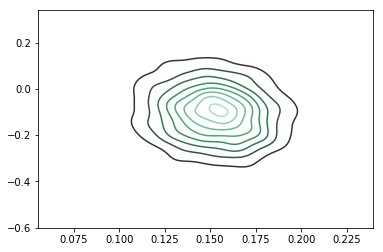

In [65]:
sns.kdeplot(samples[:,0,2,0], samples[:,11,0,3])
plt.show()

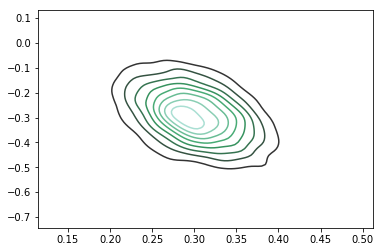

In [301]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

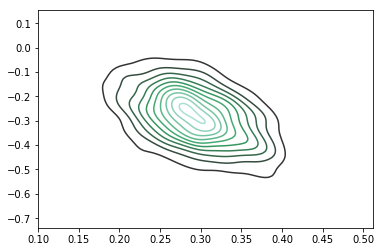

In [286]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

In [66]:
t = 14
# params[t]

In [67]:
np.mean(samples[:,t], axis=0)

array([[-0.0825,  0.0062, -0.1318, -0.0815],
       [ 0.0564,  0.1373,  0.5275,  0.036 ],
       [ 0.1206, -0.007 ,  0.9351,  0.2774]])

In [64]:
np.std(samples[:,t], axis=0)

array([[0.1049, 0.0981, 0.1117, 0.1097],
       [0.0974, 0.1036, 0.132 , 0.0985],
       [0.0473, 0.0392, 0.052 , 0.1675]])

In [163]:
np.mean(samples[:,t], axis=0)

array([[-0.2617, -0.0514, -0.1421, -1.1013],
       [ 0.0716,  0.1932,  0.6169,  0.2148],
       [ 0.2826, -0.0293,  0.8549,  0.9093]])

In [164]:
np.std(samples[:,t], axis=0)

array([[0.1349, 0.0932, 0.1238, 0.3107],
       [0.0814, 0.0982, 0.1407, 0.1506],
       [0.0623, 0.039 , 0.0645, 0.3178]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


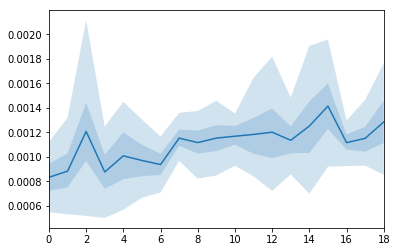

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


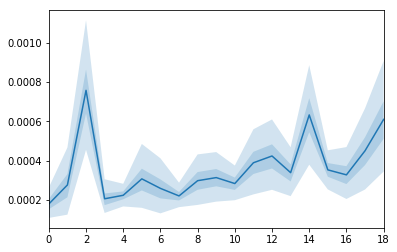

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


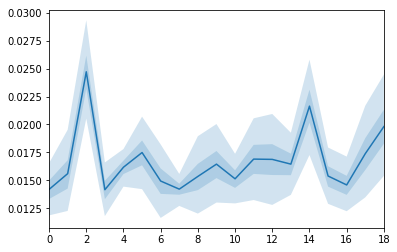

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()